In [1]:
import numpy as np
import glob2
import matplotlib.pyplot as plt
import os
import json
import itertools
import pandas as pd
import seaborn as sns

In [2]:
# Four params and their values, each is a np array
queen_bee_concentrations = [0.15]
print("Q = {}".format(queen_bee_concentrations))

worker_bee_concentrations = np.linspace(0.005, 0.4, 4)
print("W = {}".format(worker_bee_concentrations))

diffusion_coefficients = np.linspace(0.05, 0.5, 4)
print("D = {}".format(diffusion_coefficients))

worker_bee_thresholds = np.linspace(0.005, 0.5, 4)
print("T = {}".format(worker_bee_thresholds))


Q = [0.15]
W = [0.005      0.13666667 0.26833333 0.4       ]
D = [0.05 0.2  0.35 0.5 ]
T = [0.005 0.17  0.335 0.5  ]


In [4]:
# Get names of all 64 json's
json_list = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*.json")))

In [3]:
def get_matching_filenames(json_list, param_1, param_2, value_1, value_2):
    matching_json_names = []
    for i in range(len(json_list)):
        if (json_list[i].find(param_1+str(value_1)) != -1) and (json_list[i].find(param_2+str(value_2)) != -1):
            matching_json_names.append(json_list[i])
    
    return matching_json_names

In [5]:
# # Test above function on 1 set of param pair values
# names = get_matching_filenames(json_list, "Q", "W", 0.01, 0.005)
# print(names)

In [5]:
def get_ending_distances(json_file):
    # Get the 10 ending values of a single json
    with open("avg_distance_data/" + json_file, "r") as f:
        data = json.load(f)
        # print(data)
        
    # For 1 JSON of 10 replicate swarms: going through its 10 lists
    dist_list = []
    for i in range(len(data)):
        ending_dist = data[i][-1]
        dist_list.append(ending_dist)
        
    dist_avg = np.median(dist_list)
    dist_var = np.var(dist_list)
    
    return dist_avg, dist_var

In [6]:
# Testing above function
x = get_ending_distances("Q0.15_W0.4_D0.2_T0.5_wb1.json")
print(x)

(3.5108681365844023, 0.09937998992745845)


In [7]:
def get_mean_var(json_list, param_1, param_2, value_1, value_2):

    # Load in a json list and get ending value of each list, then average and variance those 160 values
    
#     param_pair_distances = []
    # print(len(param_pair_distances))
    # print(param_pair_distances[0])

    averages = []
    variances = []
    
    names = get_matching_filenames(json_list, param_1, param_2, value_1, value_2)

    for n in names:
        # print(n)
        distance_tuple = get_ending_distances(n)
        # print(distance_tuple)
        averages.append(distance_tuple[0])
        variances.append(distance_tuple[1])

#     # Merge lists in param_pair_distances
#     merged = list(itertools.chain.from_iterable(param_pair_distances))
#     # print(merged)
#     merged_mean = np.mean(merged)
#     # print(merged_mean)
#     merged_var = np.var(merged)
#     # print(merged_var)
    
#     return merged_mean, merged_var
    return np.median(averages), np.median(variances)


In [8]:
# Test above function
get_mean_var(json_list, "W", "D", 0.005, 0.5)

(0.2710220385391539, 0.04305490309735173)

In [9]:
# Test above function
get_mean_var(json_list, "W", "T", 0.4, 0.005)

(3.543978984942696, 0.089575277538329)

In [10]:
# Iterate through different pairs of params and their values

def compare_params(json_list, param_1, param_2, list_1, value_2):
    # Create one column for a W values against 4 queen values
    all_averages = []
    all_variances = []
    for item in list_1:
        # print(item)
        mean_var = get_mean_var(json_list, param_1, param_2, item, value_2)
        # print(mean_var)
        all_averages.append(mean_var[0])
        all_variances.append(mean_var[1]) 
        
    return all_averages, all_variances

In [11]:
# Test
compare_params(json_list, "W", "D", worker_bee_concentrations, 0.05)
# test_variances = compare_params(json_list, "Q", "W", queen_bee_concentrations, 0.005)
# test_means

([2.47190377581229, 2.9960197652890823, 3.0035389806609802, 3.075461099698277],
 [0.02839165601270139,
  0.02732996907465707,
  0.026551603012951855,
  0.028187384849535965])

## Returning DF 

In [25]:
def get_dataframe(json_list, param_1, list_1, param_2, list_2, avg_or_var, index_array):
    
    # Get 4 lists of values contained in cumulative list
    vals_list = []
    for val in list_2:
        if avg_or_var == "avg":
            x = compare_params(json_list, param_1, param_2, list_1, val)[0]
            vals_list.append(x)
        elif avg_or_var == "var":
            x = compare_params(json_list, param_1, param_2, list_1, val)[1]
            vals_list.append(x)
        
    # Turn into dict
    data = {}
    for i, key in enumerate(list_2):
        if len(str(key)) >= 5:
            key = "{0:.3f}".format(key)
            # print(key, type(key))
            data[key] = vals_list[i]
        else:
            # print(key, type(key))
            data[key] = vals_list[i]
            
    # Truncate labels in index_array
    new_index_array = []
    for j, label in enumerate(index_array):
        if len(str(label)) >= 5:
            new_index_array.append("{0:.3f}".format(label))
        else:
            new_index_array.append(label)
        
            
    # Turn into dataframe 
    df = pd.DataFrame(data, index=[new_index_array])

    return df


### Queen vs Worker

In [21]:
# Q_W_avg_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "W", worker_bee_concentrations, "avg", [0.01, 0.173, 0.34, 0.5])
# print("Q_W_avg_df:")
# print(Q_W_avg_df)
# print("\n")

# Q_W_var_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "W", worker_bee_concentrations, "var", [0.01, 0.173, 0.34, 0.5])
# print("Q_W_var_df:")
# print(Q_W_var_df)
# print("\n")

### Queen vs Coefficient

In [22]:
# Q_D_avg_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "D", diffusion_coefficients, "avg", [0.01, 0.173, 0.34, 0.5])
# print("Q_D_avg_df:")
# print(Q_D_avg_df)
# print("\n")

# Q_D_var_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "D", diffusion_coefficients, "var", [0.01, 0.173, 0.34, 0.5])
# print("Q_D_var_df:")
# print(Q_D_var_df)
# print("\n")

### Queen vs Threshold

In [25]:
# Q_T_avg_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "T", worker_bee_thresholds, "avg", [0.01, 0.173, 0.34, 0.5])
# print("Q_T_avg_df:")
# print(Q_T_avg_df)
# print("\n")

# Q_T_var_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "T", worker_bee_thresholds, "var", [0.01, 0.173, 0.34, 0.5])
# print("Q_T_var_df:")
# print(Q_T_var_df)
# print("\n")

### Worker vs Coefficient

In [26]:
# W_D_avg_df = get_dataframe(json_list, "W", worker_bee_concentrations, "D", diffusion_coefficients, "avg", worker_bee_concentrations)
# print("W_D_avg_df:")
# print(W_D_avg_df)
# print("\n")

# W_D_var_df = get_dataframe(json_list, "W", worker_bee_concentrations, "D", diffusion_coefficients, "var", worker_bee_concentrations)
# print("W_D_var_df:")
# print(W_D_var_df)
# print("\n")

### Worker vs Threshold

In [64]:
# W_T_avg_df = get_dataframe(json_list, "W", worker_bee_concentrations, "T", worker_bee_thresholds, "avg", worker_bee_concentrations)
# print("W_T_avg_df:")
# print(W_T_avg_df)
# print("\n")

# W_T_var_df = get_dataframe(json_list, "W", worker_bee_concentrations, "T", worker_bee_thresholds, "var", worker_bee_concentrations)
# print("W_T_var_df:")
# print(W_T_var_df)
# print("\n")

### Coefficient vs Threshold

In [65]:
# D_T_avg_df = get_dataframe(json_list, "D", diffusion_coefficients, "T", worker_bee_thresholds, "avg", diffusion_coefficients)
# print("D_T_avg_df:")
# print(D_T_avg_df)
# print("\n")

# D_T_var_df = get_dataframe(json_list, "D", diffusion_coefficients, "T", worker_bee_thresholds, "var", diffusion_coefficients)
# print("D_T_var_df:")
# print(D_T_var_df)
# print("\n")

## Plotting heatmap from dataframe for a pair of params

In [13]:
def plot_heatmap(df_avg, df_var, x_label, y_label, filename, t_value):
    
    sns.set(font_scale = 1.5)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(14,4))
    
    sns.heatmap(df_avg, cmap="Greens", cbar_kws={'label': 'Average distance'}, ax=ax1, vmin=0, vmax=4)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title('Average distance from queen')
    
    sns.heatmap(df_var, cmap="Blues", cbar_kws={'label': 'Variance distance'}, ax=ax2, vmin=0, vmax=2)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    ax2.set_title('Variance distance from queen')

    ax1.invert_yaxis()
    ax2.invert_yaxis()
    
    # ax1.set_xticks(x_ticks)

    fig.text(0.5, 1.0, "Worker activation threshold = {}".format(t_value), ha='center', va='center')
    # fig.text(-0.02, -0.1, y_label, ha='center', va='center')
    
    
#     plt.gcf().subplots_adjust(bottom=0.20, top=0.25)
    # plt.title(plot_title)
    
#     plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    
    plt.savefig('figures/param_heatmap/{}.pdf'.format(filename), bbox_inches='tight')
    

In [79]:
# plot_heatmap(Q_W_avg_df, Q_W_var_df, 'Worker concentration', 'Queen concentration', 'Queen_Worker')


In [80]:
# plot_heatmap(Q_D_avg_df, Q_D_var_df, 'Diffusion coefficient', 'Queen concentration', 'Queen_Coefficient')


In [81]:
# plot_heatmap(Q_T_avg_df, Q_T_var_df, 'Activation threshold', 'Queen concentration', 'Queen_Threshold')

In [82]:
# plot_heatmap(W_D_avg_df, W_D_var_df, 'Diffusion coefficient', 'Worker concentration', "Worker_Coefficient")


In [83]:
# plot_heatmap(W_T_avg_df, W_T_var_df, 'Activation threshold', 'Worker concentration', "Worker_Threshold")


In [84]:
# plot_heatmap(D_T_avg_df, D_T_var_df, 'Activation threshold', 'Diffusion coefficient', "Coefficient_Threshold")

## Re-plotting with 3 free parameters while Q is fixed

In [14]:
worker_bee_thresholds

array([0.005, 0.17 , 0.335, 0.5  ])

In [31]:
# Get names of all json's for a single T value - do this 4 times - each T has 16 files

jsons_T_1 = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*T{}*.json".format(worker_bee_thresholds[0]))))
jsons_T_2 = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*T{}*.json".format(worker_bee_thresholds[1]))))
jsons_T_3 = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*T{}*.json".format(worker_bee_thresholds[2]))))
jsons_T_4 = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*T{}*.json".format(worker_bee_thresholds[3]))))


In [16]:
print(len(jsons_T_3))
jsons_T_3


16


['Q0.15_W0.005_D0.05_T0.335_wb1.json',
 'Q0.15_W0.005_D0.2_T0.335_wb1.json',
 'Q0.15_W0.005_D0.35_T0.335_wb1.json',
 'Q0.15_W0.005_D0.5_T0.335_wb1.json',
 'Q0.15_W0.1366666666666667_D0.05_T0.335_wb1.json',
 'Q0.15_W0.1366666666666667_D0.2_T0.335_wb1.json',
 'Q0.15_W0.1366666666666667_D0.35_T0.335_wb1.json',
 'Q0.15_W0.1366666666666667_D0.5_T0.335_wb1.json',
 'Q0.15_W0.26833333333333337_D0.05_T0.335_wb1.json',
 'Q0.15_W0.26833333333333337_D0.2_T0.335_wb1.json',
 'Q0.15_W0.26833333333333337_D0.35_T0.335_wb1.json',
 'Q0.15_W0.26833333333333337_D0.5_T0.335_wb1.json',
 'Q0.15_W0.4_D0.05_T0.335_wb1.json',
 'Q0.15_W0.4_D0.2_T0.335_wb1.json',
 'Q0.15_W0.4_D0.35_T0.335_wb1.json',
 'Q0.15_W0.4_D0.5_T0.335_wb1.json']

### T = 0.005 heatmaps for W vs D

In [26]:
W_D_avg_df_2 = get_dataframe(jsons_T_1, "W", worker_bee_concentrations, "D", diffusion_coefficients, "avg", worker_bee_concentrations)
print("W_D_avg_df:")
print(W_D_avg_df_2)
print("\n")

W_D_var_df_2 = get_dataframe(jsons_T_1, "W", worker_bee_concentrations, "D", diffusion_coefficients, "var", worker_bee_concentrations)
print("W_D_var_df:")
print(W_D_var_df_2)
print("\n")

W_D_avg_df:
           0.05      0.20      0.35      0.50
0.005  3.064317  0.136414  0.026085  0.023287
0.137  3.241559  3.533319  3.549816  3.195584
0.268  3.212279  3.506136  3.529027  3.633548
0.268  3.212279  3.506136  3.529027  3.633548


W_D_var_df:
           0.05      0.20      0.35      0.50
0.005  0.009594  0.702563  0.000010  0.000005
0.137  0.019393  0.041867  0.858768  2.233887
0.268  0.046231  0.080667  0.106990  0.078354
0.268  0.046231  0.080667  0.106990  0.078354




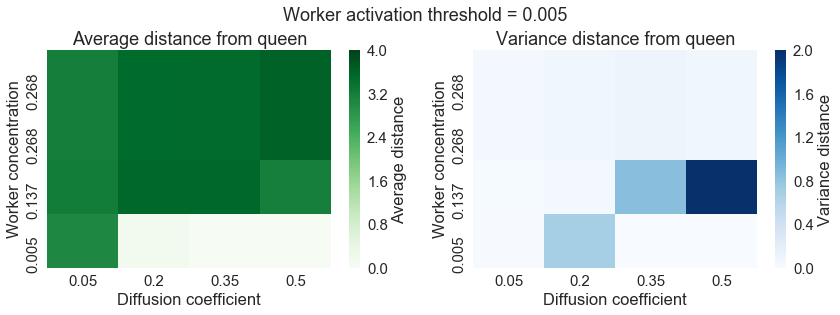

In [36]:
plot_heatmap(W_D_avg_df_2, W_D_var_df_2, 'Diffusion coefficient', 'Worker concentration', 
             "Threshold0.005_Worker_Coefficient", 0.005)


### T = 0.17 heatmaps for W vs D

In [28]:
W_D_avg_df_3 = get_dataframe(jsons_T_2, "W", worker_bee_concentrations, "D", diffusion_coefficients, "avg", worker_bee_concentrations)
print("W_D_avg_df:")
print(W_D_avg_df_3)
print("\n")

W_D_var_df_3 = get_dataframe(jsons_T_2, "W", worker_bee_concentrations, "D", diffusion_coefficients, "var", worker_bee_concentrations)
print("W_D_var_df:")
print(W_D_var_df_3)
print("\n")

W_D_avg_df:
           0.05      0.20      0.35      0.50
0.005  2.384539  1.512887  0.156213  0.047438
0.137  3.033546  3.594019  3.712951  3.764195
0.268  3.067555  3.696133  3.757741  3.623151
0.268  3.067555  3.696133  3.757741  3.623151


W_D_var_df:
           0.05      0.20      0.35      0.50
0.005  0.023935  0.138900  0.052596  0.028765
0.137  0.009110  0.101864  0.241350  0.700300
0.268  0.025920  0.060789  0.077169  0.072314
0.268  0.025920  0.060789  0.077169  0.072314




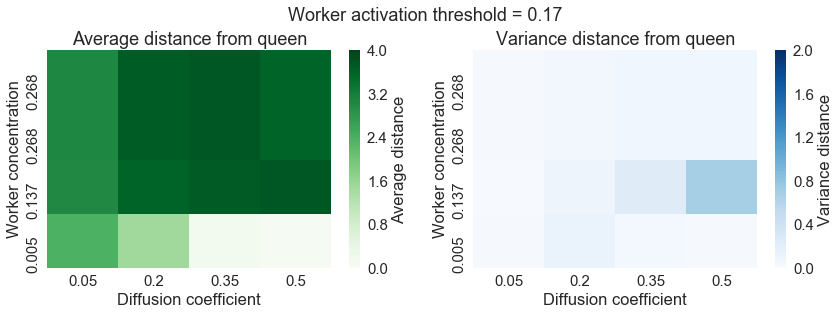

In [37]:
plot_heatmap(W_D_avg_df_3, W_D_var_df_3, 'Diffusion coefficient', 'Worker concentration', 
             "Threshold0.17_Worker_Coefficient", 0.17)


### T = 0.335 heatmaps for W vs D

In [32]:
W_D_avg_df_4 = get_dataframe(jsons_T_3, "W", worker_bee_concentrations, "D", diffusion_coefficients, "avg", worker_bee_concentrations)
print("W_D_avg_df:")
print(W_D_avg_df_4)
print("\n")

W_D_var_df_4 = get_dataframe(jsons_T_3, "W", worker_bee_concentrations, "D", diffusion_coefficients, "var", worker_bee_concentrations)
print("W_D_var_df:")
print(W_D_var_df_4)
print("\n")

W_D_avg_df:
           0.05      0.20      0.35      0.50
0.005  2.436796  2.386988  1.301770  0.494606
0.137  2.958493  3.380945  3.774114  3.772995
0.268  2.939523  3.546169  3.840162  3.763672
0.268  2.939523  3.546169  3.840162  3.763672


W_D_var_df:
           0.05      0.20      0.35      0.50
0.005  0.036225  0.119706  0.099476  0.057344
0.137  0.041285  0.082726  0.366552  0.697107
0.268  0.024783  0.117801  0.259796  0.070284
0.268  0.024783  0.117801  0.259796  0.070284




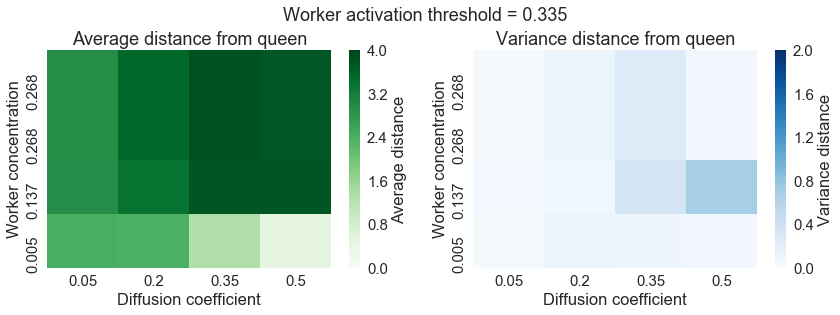

In [38]:
plot_heatmap(W_D_avg_df_4, W_D_var_df_4, 'Diffusion coefficient', 'Worker concentration', 
             "Threshold0.335_Worker_Coefficient", 0.335)


### T = 0.5 heatmaps for W vs D

In [34]:
W_D_avg_df_5 = get_dataframe(jsons_T_4, "W", worker_bee_concentrations, "D", diffusion_coefficients, "avg", worker_bee_concentrations)
print("W_D_avg_df:")
print(W_D_avg_df_5)
print("\n")

W_D_var_df_5 = get_dataframe(jsons_T_4, "W", worker_bee_concentrations, "D", diffusion_coefficients, "var", worker_bee_concentrations)
print("W_D_var_df:")
print(W_D_var_df_5)
print("\n")

W_D_avg_df:
           0.05      0.20      0.35      0.50
0.005  2.507012  2.416416  2.023315  1.203063
0.137  2.531455  3.246626  3.580474  3.683725
0.268  2.838531  3.456536  3.535559  3.747990
0.268  2.838531  3.456536  3.535559  3.747990


W_D_var_df:
           0.05      0.20      0.35      0.50
0.005  0.032848  0.048478  0.368659  0.189509
0.137  0.035267  0.063115  0.416879  0.519837
0.268  0.027183  0.082828  0.072032  0.513797
0.268  0.027183  0.082828  0.072032  0.513797




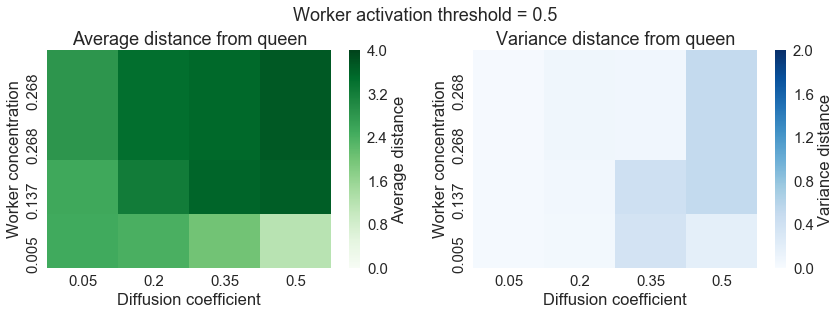

In [39]:
plot_heatmap(W_D_avg_df_5, W_D_var_df_5, 'Diffusion coefficient', 'Worker concentration', 
             "Threshold0.5_Worker_Coefficient", 0.5)
